<p style="text-align: center"> Escuela Técnica Superior de Ingeniería Informática</p>
<p style="text-align: center">Universidad de Sevilla</p>
<p style="text-align: center">Síntesis, Verificación y Razonamiento sobre Agentes Inteligentes </p>
<p style="text-align: center"> EJERCICIOS </p>
<p> </p>

**Nombre del alumno:**
- Kenny Jesús Flores Huamán

<!-- 
Para generar la tabla de contenidos que se va a haber a continuación, se ha hecho uso del siguiente código
URL : https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-a-jupyter-jupyterlab-notebook#:~:text=Click%20the%20toc2%20symbol%20in,you%20open%20it%20in%20JupyterLab.

import json
import urllib
def generate_toc(notebook_path, indent_char="&emsp;"):
    is_markdown = lambda it: "markdown" == it["cell_type"]
    is_title = lambda it: it.strip().startswith("#") and it.strip().lstrip("#").lstrip()
    with open(notebook_path, 'r') as in_f:
        nb_json = json.load(in_f)
    for cell in filter(is_markdown, nb_json["cells"]):
        for line in filter(is_title, cell["source"]):
            line = line.strip()
            indent = indent_char * (line.index(" ") - 1)
            title = line.lstrip("#").lstrip()
            url = urllib.parse.quote(title.replace(" ", "-"))
            out_line = f"{indent}[{title}](#{url})<br>\n"
            print(out_line, end="")
            
generate_toc('C6_FloresHuaman.ipynb')


-->

# Introduccion

En este notebook se van a resolver los diferentes [ejercicios planteados](https://www.cs.us.es/~fsancho/Cursos/SVRAI/Ejercicios.md.html) por el profesor mediante algunos algoritmos de Aprendizaje por Refuerzo durante la asignatura. 

Los algoritmos usados han sido basados en las notas del curso [COMP90054: Reinforcement Learning](https://gibberblot.github.io/rl-notes/intro.html) de la Universidad de Melbourne y se han añadido funcionalidades para resolver los problemas propuestos. 

En este notebook no se mostrará el código de las clases. Si desea obtener una comprensión más profunda de los algoritmos y modelos utilizados, puede revisarlos en el mismo directorio que este notebook.

## Archivos importados

A continuación se van a importar todos los archivos de python para ejecutar los diferentes algoritmos de Aprendizaje Por Refuerzo (Aunque la importación de cada ejercicio se hará en su sección).

In [1]:
from policy_iteration import PolicyIteration
from tabular_policy import TabularPolicy
from qtable import QTable
from multi_armed_bandit import EpsilonGreedy
from tabular_value_function import TabularValueFunction
from value_iteration import ValueIteration
from generic_model_free import QLearning, SARSA

import warnings
warnings.filterwarnings('ignore')

# VEHICULO EN PENDIENTE

## Version 1

Consideremos un vehículo que opera en una pendiente y utiliza paneles solares para recargarse. Puede encontrarse en uno de los tres estados de la pendiente: alto, medio y bajo. Si hace girar sus ruedas, sube la pendiente en cada paso de tiempo (de bajo a medio o de medio a alto) o se mantiene alto. Si no gira las ruedas, desciende por la pendiente en cada paso de tiempo (de alto a medio o de medio a bajo) o se mantiene bajo. Hacer girar las ruedas consume una unidad de energía por paso de tiempo. Estando en la parte alta o media de la pendiente gana tres unidades de energía por paso de tiempo a través de los paneles solares, mientras que estando en la parte baja de la pendiente no gana nada de energía por paso de tiempo. El robot quiere ganar tanta energía como sea posible

1. Representa gráficamente el MDP.
2. Resuelve el MDP utilizando la iteración de valores con un factor de descuento de 0,8.
3. Describe la política óptima.


###  Descripcion del problema

A continuación, haremos una breve descripción del problema para comprender con claridad el contexto y los desafíos que enfrentamos.

#### Espacio de estados

Existen 3 estados dentro del espacio de estados:

| Estado | Descripción |
|:---------:|:---------:|
|  LOW  | Parte baja de la pendiente |
|  MEDIUM  | Parte media de la pendiente  |
|  HIGH |  Parte alta de la pendiente  |


#### Espacio de acciones

En este problema nuestro vehículo va a poder realizar dos acciones:

| Acción | Significado |
| :---: | :---: |
| SPIN | Girar ruedas |
| NOT_SPIN | No girar las ruedas |

#### Recompensas
 * Si el vehículo está en "HIGH" o "MEDIUM" y realiza la acción "SPIN", entonces recibe una recompensa de 3 unidades de energía menos el costo de 1 unidad de energía para girar las ruedas.
 
 * Si el vehículo está en "HIGH" o "MEDIUM" y realiza la acción "NOT_SPIN", entonces recibe una recompensa de 3 unidades de energía.
 
* Si el vehículo está en "LOW" y realiza la acción "SPIN", entonces recibe una recompensa de 0 unidades de energía menos el costo de 1 unidad de energía para girar las ruedas.

* Si el vehículo está en "LOW" y realiza la acción "NOT_SPIN", entonces recibe una recompensa de 0 unidades de energía.

#### Estado inicial

El estado inicial es que empiece en la parte baja (LOW) o media (MEDIUM) de la pendiente de forma aleatoria.

####  Episodio final

No tiene definido cuando un episodio termina.



### Representacion grafica del MDP

Una vez que hemos comprendido las partes esenciales de nuestro problema, procederemos a modelarlo como un MDP utilizando la clase VehicleSlopeV1 que hereda todos los componentes necesarios de un proceso de Markov de la clase MDP.

Para representar gráficamente este problema, haremos uso de la función ```help()``` para explorar los diferentes métodos que se han desarrollado.

In [9]:
from vehiclesplope import VehicleSlopeV1

In [10]:
help(VehicleSlopeV1)

Help on class VehicleSlopeV1 in module vehiclesplope:

class VehicleSlopeV1(mdp.MDP)
 |  VehicleSlopeV1(discount_factor=0.8) -> None
 |  
 |  Clase para el problema del Vehículo en la pendiente (V1).
 |  
 |  Method resolution order:
 |      VehicleSlopeV1
 |      mdp.MDP
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, discount_factor=0.8) -> None
 |      Inicializa el problema del Vehículo en la pendiente.
 |      
 |      Args:
 |          discount_factor (float): factor de descuento. Por defecto 0.8.
 |  
 |  get_actions(self, state=None) -> List[str]
 |      Devuelve las acciones posibles en un estado determinado o en todos los estados.
 |      
 |      Args:
 |          state (str): el estado del que se quieren obtener las acciones. Por defecto None.
 |      
 |      Returns:
 |          List[str]: lista de acciones posibles.
 |  
 |  get_discount_factor(self) -> float
 |      Obtiene el factor de descuento para las recompensas futuras.
 |      
 |  

- Podemos observar que este problema hereda de la clase MDP, donde selecciona todos los métodos.
- Se han adaptado todos los métodos con *annotation typing* para que se pueda ver que valores de entrada y salida tiene cada método.
- Si queremos consultar como está desarrollado cada uno de los métodos que tiene la clase, se puede consultar el fichero ``` vehiclesplope.py```, donde se encuentra la construcción de este objeto.

### Resolucion del problema utilizando la iteracion de valores con un factor de descuento de 0,8

Para poder resolver el problema haciendo uso de iteración de valores, en primer lugar hay que realizar una instancia de nuestro problema teniendo en cuenta que el factor de descuento es 0.8.

In [4]:
vehicleV1 = VehicleSlopeV1(discount_factor=0.8)

Una vez creada la instancia del problema, hay que crear una tabla donde vamos a ir guardando los valores de cada estado, y ejecutaremos el algoritmo de iteración de valores.

In [5]:
values = TabularValueFunction()
ValueIteration(vehicleV1 ,values).value_iteration(max_iterations=100)

36

Con la función ```print_value_function(valores)``` podemos ver que valoración tiene cada uno de los estados.

In [6]:
vehicleV1.print_value_function(values)

+----------+---------------+
|  Estado  |     Valor     |
+----------+---------------+
| LOW      | 11.775        |
+----------+---------------+
| MEDIUM   | 12.219        |
+----------+---------------+
| HIGH     | 12.775        |
+----------+---------------+


### Descripcion de la politica optima.

Una vez realizado el algoritmo de iteración de valores, a partir de la función de valor, podemos extraer la política óptima del problema. Esto se puede conseguir haciendo uso de la función ```extract_policy``` de la clase ```ValueFunction```.

In [7]:
policy = values.extract_policy(vehicleV1)

Con la función ```print_policy_table```, se puede ver la política en forma de tabla.

In [8]:
policy.print_policy_table()

+---------------------------------+
| Estado   | Accion               |
+---------------------------------+
| LOW      | SPIN                 |
+---------------------------------+
| MEDIUM   | SPIN                 |
+---------------------------------+
| HIGH     | NOT_SPIN             |
+---------------------------------+


Por lo que, nuestra política óptima sería que si estamos en la **parte baja** de la pendiente, el vehículo debería realizar la acción de **girar las ruedas**, si estamos en la **parte media** de la pendiente, también deberíamos **girar las ruedas**, y finalmente, si estamos en la **parte alta**, lo más óptimo **no es girar las ruedas** del vehículo.

## Version 2 

Supongamos ahora que el vehículo puede encontrarse en uno de los cuatro estados de la pendiente: superior, alto, medio y bajo. Si gira sus ruedas lentamente, sube la pendiente en cada paso de tiempo (de bajo a medio, o de medio a alto, o de alto a superior) con una probabilidad de 0,3
, y desciende por la pendiente hasta la parte baja con una probabilidad de 0,7
. Si hace girar sus ruedas rápidamente, sube la pendiente en cada paso de tiempo (de bajo a medio, o de medio a alto, o de alto a superior) con una probabilidad de 0,7
, y se desliza por la pendiente hasta llegar abajo con una probabilidad de 0,3
. El giro lento de las ruedas consume una unidad de energía por paso de tiempo. Girar las ruedas rápidamente consume dos unidades de energía por unidad de tiempo. El vehículo se encuentra en la parte baja de la pendiente y su objetivo es llegar a la cima con el mínimo consumo de energía previsto.

1. Representa gráficamente el MDP.
2. Resuelve el MDP utilizando iteración de valor sin descuento (es decir, iteración de valor con un factor de descuento de 1).
3. Describe la política óptima.


###  Descripcion del problema

A continuación, haremos una breve descripción del problema para comprender con claridad el contexto y los desafíos que enfrentamos.

#### Espacio de estados

Existen 4 estados dentro del espacio de estados:

| Estado | Descripción |
|:---------:|:---------:|
|  LOW  | Parte baja de la pendiente |
|  MEDIUM  | Parte media de la pendiente  |
|  HIGH |  Parte alta de la pendiente  |
|  TOP |  Parte superior de la pendiente  |

#### Espacio de acciones

En este problema nuestro vehículo va a poder realizar 2 acciones:

| Acción | Significado |
| :---: | :---: |
| SPIN_FAST | Girar rápidamente las ruedas |
| SPIN_LOW | Girar lentamente las ruedas |

#### Recompensas

* Si ha llegado a la cima de la pendiente (TOP), entonces la recompensa es de 0.
* Si el vehículo toma la acción de girar las ruedas rápidamente (SPIN_FAST), entonces la recompensa es de -2.
* Si el vehículo toma la acción de girar las ruedas lentamente (SPIN_LOW), entonces la recompensa es de -1.

#### Estado inicial

El estado inicial es que empiece en la parte baja (LOW) de la pendiente.

####  Episodio final

Termina cuando el vehículo llega a la cima (TOP).

### Representacion grafica del problema

Para poder representar este problema, también se va a hacer uso de la función ```help``` para ver los diferentes métodos que contiene la clase.

In [2]:
from vehiclesplope import VehicleSlopeV2

In [3]:
help(VehicleSlopeV2)

Help on class VehicleSlopeV2 in module vehiclesplope:

class VehicleSlopeV2(mdp.MDP)
 |  VehicleSlopeV2(discount_factor: float = 1.0, initial_state: str = 'LOW') -> None
 |  
 |  Clase para el problema del Vehículo en la pendiente (V2).
 |  
 |  Method resolution order:
 |      VehicleSlopeV2
 |      mdp.MDP
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, discount_factor: float = 1.0, initial_state: str = 'LOW') -> None
 |      Inicializa el problema del Vehículo en la pendiente.
 |      
 |      Args:
 |          discount_factor (float): factor de descuento. Por defecto 0.8.
 |          initial_state (str): estado inicial. Por defecto "LOW".
 |  
 |  get_actions(self, state=None) -> List[str]
 |      Devuelve las acciones posibles en un estado determinado o en todos los estados.
 |      
 |      Args:
 |          state (str): el estado del que se quieren obtener las acciones. Por defecto None.
 |      
 |      Returns:
 |          List[str]: lista de acc

- Podemos observar que este problema hereda de la clase MDP, donde selecciona todos los métodos.
- Se han adaptado todos los métodos con *annotation typing* para que se pueda ver que valores de entrada y salida tiene cada método.
- Si queremos consultar como está desarrollado cada uno de los métodos que tiene la clase, se puede consultar el fichero ``` vehiclesplope.py```, donde se encuentra la construcción de este objeto.

### Resolucion del problema utilizando la iteración de valores sin descuento

Para poder resolver el problema haciendo uso de iteración de valores, en primer lugar hay que realizar una instancia de nuestro problema teniendo en cuenta que el factor de descuento es 1

In [9]:
vehicleV2 = VehicleSlopeV2(discount_factor=1.)

Una vez creada la instancia del problema, hay que crear una tabla donde vamos a ir guardando los valores de cada estado, y ejecutaremos el algoritmo de iteración de valores.

In [10]:
values = TabularValueFunction()
ValueIteration(vehicleV2 ,values).value_iteration(max_iterations=100)

39

Esta clase también cuenta con la función ```print_value_function```, para ver los diferentes valores en cada estado.

In [11]:
vehicleV2.print_value_function(values)

+----------+---------------+
|  Estado  |     Valor     |
+----------+---------------+
| LOW      | -10.766       |
+----------+---------------+
| MEDIUM   | -7.91         |
+----------+---------------+
| HIGH     | -3.83         |
+----------+---------------+
| TOP      | 0.0           |
+----------+---------------+


### Descripcion de la politica optima

Una vez realizado el algoritmo de iteración de valores, a partir de la función de valor, podemos extraer la política óptima del problema. Esto se puede conseguir haciendo uso de la función ```extract_policy``` de la clase ```ValueFunction```.

In [12]:
policy = values.extract_policy(vehicleV2)

In [13]:
policy.print_policy_table()

+---------------------------------+
| Estado   | Accion               |
+---------------------------------+
| LOW      | SPIN_FAST            |
+---------------------------------+
| MEDIUM   | SPIN_FAST            |
+---------------------------------+
| HIGH     | SPIN_FAST            |
+---------------------------------+
| TOP      | SPIN_LOW             |
+---------------------------------+


Con un factor de descuento de 1, la política óptima siempre va a ser **girar las ruedas rápidamente**, debido a que tiene una mayor probabilidad de éxito y el consumo de energía no importa ya que no hay descuento en el futuro. En la cima (TOP), no hay que hacer nada, ya que es el estado terminal, así que no importa que acción tome.

# MUNDO MALLA 

El ejemplo de mundo malla es una idealización del movimiento de un robot en un entorno. En cada momento, el robot se encuentra en una ubicación y puede desplazarse a las ubicaciones vecinas, recogiendo recompensas y castigos. Supongamos que las acciones son estocásticas, de modo que existe una distribución de probabilidad sobre los estados resultantes dada la acción y el estado.

![Descripción de la imagen](grid.png)


En la figura adjunta se muestra un mundo cuadriculado de 10×10
, en el que el robot puede elegir una de cuatro acciones: arriba, abajo, izquierda o derecha. Si el agente lleva a cabo una de estas acciones, tiene una probabilidad de 0.7
 de dar un paso en la dirección deseada y una probabilidad de 0.1
 de dar un paso en cualquiera de las otras tres direcciones. Si choca contra la pared exterior (es decir, la ubicación calculada está fuera de la malla), tiene una penalización de 1
 (es decir, una recompensa de −1
) y el agente no se mueve. Hay cuatro estados con recompensa (aparte de las paredes): +10
 (en la posición (9,8)
), +3
 (en (8,3)
), −5
 (en (4,5)
) y −10
 (en (4,8)
). En cada uno de estos estados, el agente obtiene la recompensa después de realizar una acción en ese estado, no cuando entra en él. Cuando el agente alcanza uno de los estados con recompensa positiva (ya sea +3
 o +10
), independientemente de la acción que realice, en el siguiente paso es lanzado, al azar, a una de las cuatro esquinas del mundo cuadriculado.

1. Representa gráficamente el MDP.
2. Resuelve el MDP por diversos métodos.
3. Describe la política óptima.

## Descripcion del problema 

### Espacio de estados

Cada estado está formado por una tupla donde cada elemento corresponde a las siguientes características:

| Nombre | Descripción |
|:---------:|:---------:|
|  x  | Posición del robot en el eje x |
|  y  | Posición del robot en el eje y |

Al visualizar los estados en este tipo de problemas, es importante tener en cuenta que la coordenada (0,0) del agente corresponde al [punto de partida (start)](https://courses.grainger.illinois.edu/cs440/fa2018/lectures/lect29.html), como se muestra en la siguiente imagen mostrada. Esto significa que el resto de las coordenadas seguirán la misma distribución, y es  necesario ajustar la posición de las recompensas que se mencionan en el problema para que coincidan con la ubicación correcta.

<img src="gridworld-diagram.jpg" width="40%">

Además, es importante recordar que Python es un lenguaje de programación que sigue la filosofía del **0-indexing** para los arrays. Esto significa que todas las posiciones se contarán a partir de (0,0) hasta (nfilas-1,ncolumnas-1).


### Espacio de acciones

En este problema nuestro robot va a poder realizar diferentes acciones

| Acción | Significado |
| :---: | :---: |
| UP | Ir hacia arriba|
| DOWN | Ir hacia abajo |
| LEFT | Ir hacia la izquierda |
| RIGHT | Ir hacia la derecha |


### Recompensas

* Si el estado en el que estamos es una recompensa y el siguiente estado nos lleva a una finalización, entonces la recompensa es el valor de lo que haya en ese cuadrado.
* Si no, la recompensa es 0.

### Estado inicial

El estado inicial de nuestro problema es el (0,0)

###  Episodio final
Cuando haya llegado alguna de las recompensas.

## Representacion grafica del problema

Para mostrar los diferentes métodos de la clase, podemos hacer uso de ```help``` como hemos visto anteriormente para mostrar los elementos.

In [2]:
from gridworld import GridWorld

pygame 2.1.3.dev8 (SDL 2.26.1, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
help(GridWorld)

Help on class GridWorld in module gridworld:

class GridWorld(mdp.MDP)
 |  GridWorld(noise=0.3, width=10, height=10, discount_factor=0.9, action_cost=0.0, initial_state=(0, 0), goals=None) -> None
 |  
 |  GridWorld es una clase que representa el entorno del problema del Mundo Malla. En este problema es un entorno discreto
 |  que representa la cuadrícula donde un agente debe moverse entre las celdas.
 |  
 |  Method resolution order:
 |      GridWorld
 |      mdp.MDP
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, noise=0.3, width=10, height=10, discount_factor=0.9, action_cost=0.0, initial_state=(0, 0), goals=None) -> None
 |      Crea una instancia del problema Mundo Malla.
 |      
 |      Args:
 |          noise (float): el ruido que introduce el entorno en la acción del agente. Por defecto es 0.3.
 |          width (int): la anchura de la cuadrícula. Por defecto es 10.
 |          height (int): la altura de la cuadrícula. Por defecto es 10.
 |      

Ahora vamos a crear una instancia del problema con los estados que tienen recompensa con la posición modelada en nuestro modelo.

In [4]:
gridworld = GridWorld(goals=[((8, 2), +10), ((7, 7), +3),
                     ((3, 5), -5), ((3, 2), -10)])

Para verlo de una manera mucho más clara los estados, se ha usado pygame para crear una visualización del estado inicial

In [5]:
gridworld.visualise_initial_state()

SystemExit: 

## Resolucion del problema por diversos métodos

A continuación, vamos a ver la resolución del problema mediante diversos algoritmos de Aprendizaje por Refuerzo.

### Resolucion del MDP mediante Iteración de valores

In [6]:
gridworldI = GridWorld(goals=[((8, 2), +10), ((7, 7), +3),
                     ((3, 5), -5), ((3, 2), -10)])

In [7]:
values_gridworldI = TabularValueFunction()
ValueIteration(gridworld, values_gridworldI).value_iteration(max_iterations=100)
p_gridworldI = values_gridworldI.extract_policy(gridworldI)
print(gridworldI.policy_to_string(p_gridworldI))


  |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓  |  ↓ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  →  | 3  |  ↓  |  ↓ 
 |  →  |  →  |  →  |  ↑  |  →  |  →  |  →  |  →  |  ↓  |  ↓ 
 |  ↓  |  →  |  ←  | -5  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓ 
 |  ↓  |  →  |  →  |  ↓  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓ 
 |  ↓  |  →  |  →  |  ↑  |  →  |  →  |  →  |  →  |  ↓  |  ↓ 
 |  ↓  |  →  |  ←  | -10  |  →  |  →  |  →  |  →  | 10  |  ← 
 |  ↓  |  →  |  →  |  ↓  |  →  |  →  |  →  |  →  |  ↑  |  ↑ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  ↑  |  ↑ 



In [8]:
p_gridworldI.print_policy_table(15,10)

+------------------------------+
| Estado          | Accion     |
+------------------------------+
| ('end', 'end')  | end        |
+------------------------------+
| (0, 0)          | RIGHT      |
+------------------------------+
| (0, 1)          | DOWN       |
+------------------------------+
| (0, 2)          | DOWN       |
+------------------------------+
| (0, 3)          | DOWN       |
+------------------------------+
| (0, 4)          | DOWN       |
+------------------------------+
| (0, 5)          | DOWN       |
+------------------------------+
| (0, 6)          | RIGHT      |
+------------------------------+
| (0, 7)          | RIGHT      |
+------------------------------+
| (0, 8)          | RIGHT      |
+------------------------------+
| (0, 9)          | RIGHT      |
+------------------------------+
| (1, 0)          | RIGHT      |
+------------------------------+
| (1, 1)          | RIGHT      |
+------------------------------+
| (1, 2)          | RIGHT      |
+---------

### Resolucion del MDP mediante Iteración de políticas

In [9]:
gridworldII = GridWorld(goals=[((8, 2), +10), ((7, 7), +3),
                     ((3, 5), -5), ((3, 2), -10)])

In [10]:
p_gridworldII = TabularPolicy(default_action=gridworld.UP)
PolicyIteration(gridworldII, p_gridworldII).policy_iteration(max_iterations=300)
print(gridworldII.policy_to_string(p_gridworldII))


  |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓  |  ↓ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  →  | 3  |  ↓  |  ↓ 
 |  →  |  →  |  →  |  ↑  |  →  |  →  |  →  |  →  |  ↓  |  ↓ 
 |  ↓  |  →  |  ←  | -5  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓ 
 |  ↓  |  →  |  →  |  ↓  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓ 
 |  ↓  |  →  |  →  |  ↑  |  →  |  →  |  →  |  →  |  ↓  |  ↓ 
 |  ↓  |  →  |  ←  | -10  |  →  |  →  |  →  |  →  | 10  |  ← 
 |  ↓  |  →  |  →  |  ↓  |  →  |  →  |  →  |  →  |  ↑  |  ↑ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  ↑  |  ↑ 



In [11]:
p_gridworldII.print_policy_table(15,10)

+------------------------------+
| Estado          | Accion     |
+------------------------------+
| ('end', 'end')  | end        |
+------------------------------+
| (0, 0)          | RIGHT      |
+------------------------------+
| (0, 1)          | DOWN       |
+------------------------------+
| (0, 2)          | DOWN       |
+------------------------------+
| (0, 3)          | DOWN       |
+------------------------------+
| (0, 4)          | DOWN       |
+------------------------------+
| (0, 5)          | DOWN       |
+------------------------------+
| (0, 6)          | RIGHT      |
+------------------------------+
| (0, 7)          | RIGHT      |
+------------------------------+
| (0, 8)          | RIGHT      |
+------------------------------+
| (0, 9)          | RIGHT      |
+------------------------------+
| (1, 0)          | RIGHT      |
+------------------------------+
| (1, 1)          | RIGHT      |
+------------------------------+
| (1, 2)          | RIGHT      |
+---------

### Resolucion del MDP mediante Q-Learning

In [12]:
gridworldIII = GridWorld(goals=[((8, 2), +10), ((7, 7), +3),
                     ((3, 5), -5), ((3, 2), -10)])

In [13]:
qfunction = QTable()
QLearning(gridworldIII, EpsilonGreedy(), qfunction).execute(episodes=10000)
p_gridworldIII = qfunction.extract_policy(gridworldIII)

Episodes: 100%|█████████████████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.14it/s]


In [14]:
print(gridworldIII.policy_to_string(p_gridworldIII))  


  |  ↓  |  →  |  →  |  →  |  →  |  →  |  →  |  ↓  |  ←  |  ↓ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓  |  ← 
 |  →  |  →  |  →  |  →  |  →  |  →  |  →  | 3  |  ←  |  ← 
 |  ↑  |  →  |  →  |  ↑  |  →  |  →  |  →  |  →  |  ←  |  ↑ 
 |  ↑  |  →  |  ←  | -5  |  →  |  ↓  |  →  |  ↓  |  ←  |  ↑ 
 |  →  |  →  |  →  |  ↓  |  →  |  ↓  |  ↓  |  →  |  ↓  |  ↓ 
 |  ↑  |  →  |  →  |  ↑  |  →  |  →  |  →  |  →  |  ←  |  ↓ 
 |  ↓  |  →  |  ←  | -10  |  →  |  →  |  →  |  →  | 10  |  ← 
 |  →  |  →  |  →  |  ↓  |  →  |  →  |  →  |  →  |  ↑  |  ↑ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  ↑  |  ← 



### Resolucion del MDP mediante Sarsa

In [15]:
gridworldIV = GridWorld(goals=[((8, 2), +10), ((7, 7), +3),
                     ((3, 5), -5), ((3, 2), -10)])

In [16]:
qfunction = QTable()
SARSA(gridworldIV, EpsilonGreedy(), qfunction).execute(episodes=10000)
p_gridworldIV = qfunction.extract_policy(gridworldIV)

Episodes: 100%|█████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 370.26it/s]


In [17]:
print(gridworldIV.policy_to_string(p_gridworldIV))  


  |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  ↓  |  ←  |  ← 
 |  ↑  |  →  |  →  |  →  |  →  |  ↓  |  →  |  ↓  |  ↓  |  ↑ 
 |  ↑  |  →  |  →  |  ↑  |  →  |  →  |  →  | 3  |  ←  |  ↑ 
 |  ↑  |  ↑  |  ↑  |  ↑  |  →  |  →  |  →  |  →  |  ↑  |  ↑ 
 |  ↑  |  ←  |  ←  | -5  |  →  |  →  |  →  |  ↑  |  ←  |  ↑ 
 |  ←  |  ←  |  ←  |  ↓  |  →  |  →  |  →  |  ↓  |  ↓  |  ← 
 |  ↓  |  ↓  |  ↑  |  ↑  |  →  |  →  |  →  |  →  |  ↓  |  ↓ 
 |  ↓  |  ←  |  ←  | -10  |  →  |  →  |  →  |  →  | 10  |  ↓ 
 |  ↓  |  ↓  |  ↓  |  ↓  |  →  |  →  |  →  |  ↑  |  ↑  |  ↑ 
 |  →  |  →  |  →  |  ↓  |  →  |  →  |  →  |  ↑  |  ↑  |  ← 



## Descripción de la política óptima

Viendo la resolución de todos los algoritmos, la política óptima es la siguiente:

In [18]:
print(gridworldII.policy_to_string(p_gridworldII))  


  |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓  |  ↓ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  →  | 3  |  ↓  |  ↓ 
 |  →  |  →  |  →  |  ↑  |  →  |  →  |  →  |  →  |  ↓  |  ↓ 
 |  ↓  |  →  |  ←  | -5  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓ 
 |  ↓  |  →  |  →  |  ↓  |  →  |  →  |  →  |  ↓  |  ↓  |  ↓ 
 |  ↓  |  →  |  →  |  ↑  |  →  |  →  |  →  |  →  |  ↓  |  ↓ 
 |  ↓  |  →  |  ←  | -10  |  →  |  →  |  →  |  →  | 10  |  ← 
 |  ↓  |  →  |  →  |  ↓  |  →  |  →  |  →  |  →  |  ↑  |  ↑ 
 |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  →  |  ↑  |  ↑ 



# CartPole

Este problema, también llamado a veces problema de equilibrio de pértiga, permite que el agente mueva un carro horizontalmente. Como se muestra en la figura, el carro tiene una pértiga rígida unida a él por una rótula, de modo que cuando el carro se mueve hacia la derecha o izquierda, la pértiga puede girar alrededor de la unión. El objetivo es mantener el poste verticalmente equilibrado mientras se mantiene el carro dentro de los límites laterales permitidos. Se obtiene 1
 de recompensa cada unidad de tiempo en el que la pértiga no supera cierto ángulo de inclinación y el carro se encuentra dentro de ciertos límites laterales, y la transición a un estado terminal de recompensa 0
 se produce en caso contrario.

Las acciones consisten en aplicar una fuerza F
 a la izquierda o a la derecha del carro. El espacio de estados está definido por cuatro variables continuas: la posición lateral del carro x
, su velocidad lateral v
, el ángulo de la pértiga θ
 y la velocidad angular de la pértiga w
. Además, el problema involucra una variedad de parámetros necesarios para el modelado físico, que incluyen: la masa del carro $m_{cart}$
, la masa de la pértiga $m_{pole}$
, la longitud de la pértiga l
, la magnitud de la fuerza |F|
, la aceleración gravitacional g
, el paso de tiempo $Δt$
, la desviación x
 máxima, la desviación angular máxima, y las pérdidas por fricción entre el carro y la pértiga o entre el carro y la pista.
 
 Dada una fuerza de entrada $F$, la aceleración angular de la pértiga es
$$
\alpha=\frac{g \sin (\theta)-\tau \cos (\theta)}{\frac{l}{2}\left(\frac{4}{3}-\frac{m_{\text {pole }}}{m_{\text {cart }}+m_{\text {pole }}} \cos (\theta)^2\right)} \quad, \quad \text { donde: } \quad \tau=\frac{F+w^2 l \sin \theta / 2}{m_{\text {cart }}+m_{\text {pole }}}
$$
y la aceleración lateral del carro es:
$$
a=\tau-\frac{l}{2} \alpha \cos (\theta) \frac{m_{\text {pole }}}{m_{\text {cart }}+m_{\text {pole }}}
$$
El estado se actualiza a partir de la integración de Euler:
$$
\begin{aligned}
& x \leftarrow x+v \Delta t \\
& v \leftarrow v+a \Delta t \\
& \theta \leftarrow \theta+w \Delta t \\
& x \leftarrow w+\alpha \Delta t
\end{aligned}
$$

El problema se inicializa normalmente con valores aleatorios extraídos de una distribución uniforme, $U(-0.05,0.05)$. La ejecución se detiene cuando se superan las desviaciones laterales o angulares.

## Descripcion del problema 

### Espacio de estados

Cada estado está formado por una 4-tupla donde cada elemento corresponde a las siguientes características:

| Nombre | Descripción | Mín| Max |
|:---------:|:---------:|:---------:|:---------:|
|  x  | Posición del carro |-4.8  | 4.8  |
|  x_dot  |  Velocidad del carro |  -inf  |  inf |
|  theta  |  Ángulo del poste  |  rad (-24°) | rad (24°)  |
|  theta_dot  |   Velocidad angular del poste  |  -inf  |  inf |


Observando nuestros elementos, el espacio de estado es infinito debido a que estamos trabajando con valores contínuos. Esto haría que algoritmos como Q-Learning no puedan realizarse.

Sin embargo, si quisiéramos hacer uso de Q-Learning en este problema, una de las técnicas más usadas es el discretizar el espacio de estados (aunque también podríamos hacerlo con las acciones si fueran contínuas). 

La técnica de discretizar el espacio implica dividir el espacio de estado en un número finito de estados discretos. Y una vez realizado esta técnica, ya podemos hacer uso de Q-Learning sin ningún problema.


<img src="div_carpole.png" alt="https://eprints.ucm.es/id/eprint/56648/1/1138035127-327684_JUAN_RAM%C3%93N_DEL_CA%C3%91O_VEGA_Aprendizaje_por_refuerzo_profundo_aplicado_a_juegos_sencillos_3940146_998640412.pdf" width="50%">

Para realizar esto, habrá que realizar la división de nuestras observaciones en buckets, donde cada elemento del bucket, representa un rango de valores que están dentro del cubo.

Siguiendo el artículo [Balancing a CartPole System with Reinforcement Learning -- A Tutorial](https://arxiv.org/abs/2006.04938), una forma de dividir cada estado sería en los siguientes buckets (1, 1, 6, 3). Por lo que la dimensión de la Q-Table sería 1x1x6x3x2 (una dimensionalidad que el Q-Learning puede aceptar)

### Espacio de acciones

En este problema nuestro carro va a poder realizar dos acciones:

| Acción | Significado |
| :---: | :---: |
| 0 | Empujar el carro hacia la izquierda |
| 1 | Empujar el carro hacia la derecha |

### Recompensas

Se obtiene 1 de recompensa si el poste no supera cierto ángulo de inclinación y el carro se encuentra dentro de los límites, y cuando estamos a un estado terminar se da recompensa 0.

### Estado inicial

Todas las observaciones se han asignado con valores uniformes en el rango (-0.05,0.05).

###  Episodio final

Un episodio finaliza si el ángulo del poste theta es mayor que $\pm 0.20944$ radianes o si la posición del carro es mayor a $\pm 2.4)$.



## Representacion gráfica del problema

In [2]:
from cartpole import CartPole, QLearningCartPole, SARSACartPole

Para mostrar los diferentes métodos de la clase, podemos hacer uso de ```help``` como hemos visto anteriormente para mostrar los elementos.

In [3]:
help(CartPole)

Help on class CartPole in module cartpole:

class CartPole(builtins.object)
 |  CartPole() -> None
 |  
 |  Clase que establece los parámetros necesarios para simular el problema CartPole.
 |  
 |  Methods defined here:
 |  
 |  __init__(self) -> None
 |      Inicialización de la clase
 |  
 |  execute(self, action: int)
 |      Ejecuta la acción dada en el estado actual y devuelve la siguiente tupla de estado-recompensa.
 |      
 |      Args:
 |          state: Una tupla que contiene los valores del estado actual.
 |          action (int): Un valor entero que representa la acción que se va a ejecutar.
 |      
 |      Returns:
 |          Una tupla que contiene el siguiente estado, la recompensa y la condición si ha llegado a un estado terminal
 |  
 |  get_actions(self, state) -> List[int]
 |      Devuelve una lista de posibles acciones que se pueden tomar en el estado actual.
 |      
 |      Args:
 |      state : Una tupla que contiene los valores del estado actual.
 |      
 |   

## Resolucion mediante Q-Learning

Para la realización de este problema, no nos servía la clase Genérica de Q-Learning debido a que necesitamos tener en cuenta algunas condiciones especiales del problema, por lo cual hicimos una adaptación del Q-Learning dentro de nuestro problema.

In [19]:
from cartpole import CartPole, QLearningCartPole, SARSACartPole

Episodio 0, Recompensa total: 17.0, Epsilon: 1.0
Episodio 100, Recompensa total: 9.0, Epsilon: 0.3936186348893951
Episodio 200, Recompensa total: 13.0, Epsilon: 0.1
Episodio 300, Recompensa total: 16.0, Epsilon: 0.1
Episodio 400, Recompensa total: 15.0, Epsilon: 0.1
Episodio 500, Recompensa total: 9.0, Epsilon: 0.1
Episodio 600, Recompensa total: 9.0, Epsilon: 0.1
Episodio 700, Recompensa total: 9.0, Epsilon: 0.1
Episodio 800, Recompensa total: 9.0, Epsilon: 0.1
Episodio 900, Recompensa total: 16.0, Epsilon: 0.1
Episodio 1000, Recompensa total: 13.0, Epsilon: 0.1
Episodio 1100, Recompensa total: 9.0, Epsilon: 0.1
Episodio 1200, Recompensa total: 13.0, Epsilon: 0.1
Episodio 1300, Recompensa total: 13.0, Epsilon: 0.1
Episodio 1400, Recompensa total: 16.0, Epsilon: 0.1
Episodio 1500, Recompensa total: 13.0, Epsilon: 0.1
Episodio 1600, Recompensa total: 13.0, Epsilon: 0.1
Episodio 1700, Recompensa total: 13.0, Epsilon: 0.1
Episodio 1800, Recompensa total: 10.0, Epsilon: 0.1
Episodio 1900, 

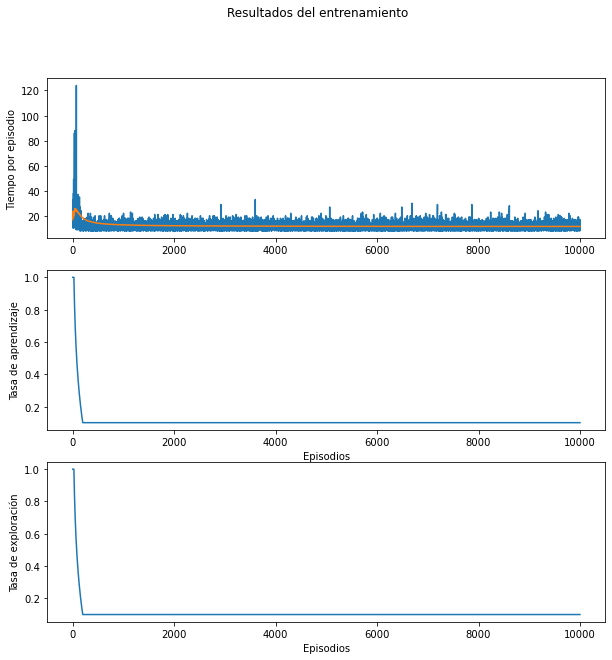

In [20]:
cartpole = CartPole()
qfunction = QTable()
al = QLearningCartPole(cartpole, EpsilonGreedy(), qfunction,print_info=False).execute(episodes=10000)

La solución más rápida que se consiguió fueron en 240 episodios.

## Resolucion mediante Sarsa

Episodio 0, Recompensa total: 23.0, Epsilon: 1.0
Episodio 100, Recompensa total: 29.0, Epsilon: 0.3936186348893951
Episodio 200, Recompensa total: 10.0, Epsilon: 0.1
Episodio 300, Recompensa total: 9.0, Epsilon: 0.1
Episodio 400, Recompensa total: 9.0, Epsilon: 0.1
Episodio 500, Recompensa total: 11.0, Epsilon: 0.1
Episodio 600, Recompensa total: 9.0, Epsilon: 0.1
Episodio 700, Recompensa total: 21.0, Epsilon: 0.1
Episodio 800, Recompensa total: 13.0, Epsilon: 0.1
Episodio 900, Recompensa total: 16.0, Epsilon: 0.1
Episodio 1000, Recompensa total: 9.0, Epsilon: 0.1
Episodio 1100, Recompensa total: 9.0, Epsilon: 0.1
Episodio 1200, Recompensa total: 10.0, Epsilon: 0.1
Episodio 1300, Recompensa total: 10.0, Epsilon: 0.1
Episodio 1400, Recompensa total: 11.0, Epsilon: 0.1
Episodio 1500, Recompensa total: 9.0, Epsilon: 0.1
Episodio 1600, Recompensa total: 9.0, Epsilon: 0.1
Episodio 1700, Recompensa total: 9.0, Epsilon: 0.1
Episodio 1800, Recompensa total: 9.0, Epsilon: 0.1
Episodio 1900, Rec

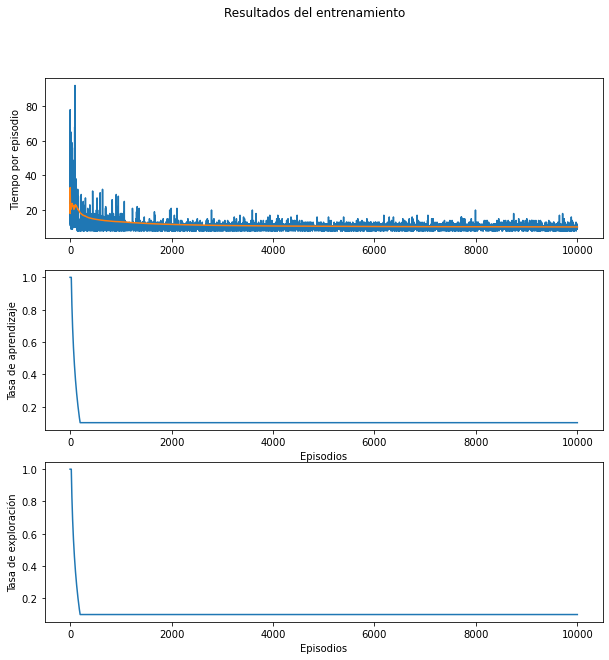

In [18]:
cartpole = CartPole()
qfunction = QTable()
SARSACartPole(cartpole, EpsilonGreedy(), qfunction,print_info=False).execute(episodes=10000)

Podemos observar que Q-Learning nos da valores mucho más altos que el algoritmo Sarsa. Aunque viendo las gráficas de recompensas por episodio, podemos observar que en vez de ir creciendo exponencialmente para luego estabilizarse, no llega a las 200 unidades de tiempo que pusimos como objetivo, por lo cual, se podría decir que este modelo no está bien entrenado.

Se ha intentado probar con otras estrategias, probando distintos buckets como realizar que la explotación y exploración sean de forma dinámica, y sigue ocurriendo los mismos gráficos.

# Mountain Car

En el problema del coche de montaña un vehículo debe conducir hacia la derecha para salir de un valle. Las paredes del valle son lo suficientemente empinadas como para que acelerar a ciegas hacia la meta con una velocidad insuficiente haga que el vehículo se detenga y se deslice hacia abajo. El agente debe aprender a acelerar primero hacia la izquierda para ganar suficiente impulso en el retorno y poder subir la colina.

El estado es la posición horizontal del vehículo $x \in[−1.2,0.6]$
 y la velocidad $v \in[−0.07,0.07]$
. En cualquier paso de tiempo, el vehículo puede acelerar a la izquierda $(a=−1)$, acelerar a la derecha $(a=1)$, o dejarse llevar por la inercia $(a=0)$. Recibimos una recompensa de −1
 en cada cambio de sentido, y terminamos cuando el vehículo llega al lado derecho del valle más allá de x=0.6
.

La figura adjunta muestra una visualización animada de una ejecución del problema.

Las transiciones en el problema del coche de montaña son deterministas:

$$
\begin{aligned}
& v' \leftarrow v+0.001 a - 0.0025 cos(3x) \\
& x' \leftarrow x+v'
\end{aligned}
$$

El término gravitacional en la actualización de la velocidad es lo que impulsa al vehículo con poca potencia hacia el fondo del valle. Las transiciones se sujetan a los límites del espacio de estados.

El problema del coche de montaña es un buen ejemplo de un problema con retorno retardado. Se requieren muchas acciones para llegar al estado objetivo, lo que dificulta que un agente no entrenado reciba algo más que penalizaciones unitarias de forma continua. Los mejores algoritmos de aprendizaje son capaces de propagar eficazmente el conocimiento de las trayectorias que llegan a la meta al resto del espacio de estados.

## Descripcion del problema 

### Espacio de estados

Cada estado está formado por una 2-tupla donde cada elemento corresponde a las siguientes características:

| Nombre | Descripción |
|:---------:|:---------:|
|  pos | Posición del vehículo |
|  velocity  |  Velocidad del vehículo |

Observando nuestros elementos, el espacio de estado  de este problema también es infinito, debido a que estamos trabajando con valores contínuos. Esto haría que algoritmos como Q-Learning no puedan realizarse.

Por lo que podemos volver a realizar discretiación para que tengamos un espacio de estados mucho más pequeño y manejable para nuestro algoritmo.

### Espacio de acciones

En este problema nuestro carro va a poder realizar dos acciones:

| Acción | Significado |
| :---: | :---: |
| -1 | Acelerar a la izquierda |
| 0 | No acelerar |
| 1 | Acelerar a la derecha |

### Recompensas

El objetivo es alcanzar la bandera situada en lo alto de la colina de la derecha lo más rápido posible, por lo que el agente es penalizado con una recompensa de -1 por cada paso de tiempo.

### Estado inicial

La posición inicial va a estar dada por una distribución uniforme U(-0.6, -0.4).

###  Episodio final

Se termina el algoritmo cuando la posición del vehículo >= 0.6

In [7]:
help(MountainCar)

Help on class MountainCar in module mountaincar:

class MountainCar(builtins.object)
 |  MountainCar() -> None
 |  
 |  Clase que establece los parámetros necesarios para simular el problema del coche en la montaña.
 |  
 |  Methods defined here:
 |  
 |  __init__(self) -> None
 |      Inicializa los parámetros del problema.
 |  
 |  execute(self, action: int)
 |      Ejecuta la acción dada en el estado actual y devuelve el siguiente estado
 |      y la recompensa obtenida.
 |      
 |      Args:
 |          state (Tuple[float,float]): El estado actual.
 |          action (int): La acción a realizar.
 |      
 |      Returns:
 |          Una tupla con el siguiente estado,la recompensa obtenida y condición si ha terminado
 |  
 |  get_actions(self, state) -> List[int]
 |      Devuelve una lista con las acciones posibles en el estado actual.
 |      
 |      Args:
 |          state: El estado actual.
 |      
 |      Returns:
 |          Una lista con las acciones posibles (-1, 0, 1).
 |

## Resolucion del problema mediante Q-Learning

In [4]:
from policy_iteration import PolicyIteration
from tabular_policy import TabularPolicy
from qtable import QTable
from multi_armed_bandit import EpsilonGreedy
from tabular_value_function import TabularValueFunction
from value_iteration import ValueIteration
from mountaincar import MountainCar, QLearningMountainCar, SARSAMountainCar

episode: 0, score: 0, epsilon: 1.000
episode: 100, score: -4909.0, epsilon: 0.980
episode: 200, score: -11338.0, epsilon: 0.960
episode: 300, score: -20617.0, epsilon: 0.940
episode: 400, score: -6302.0, epsilon: 0.920
episode: 500, score: -7738.0, epsilon: 0.900
episode: 600, score: -818.0, epsilon: 0.880
episode: 700, score: -1558.0, epsilon: 0.860
episode: 800, score: -1289.0, epsilon: 0.840
episode: 900, score: -946.0, epsilon: 0.820
episode: 1000, score: -1145.0, epsilon: 0.800
episode: 1100, score: -768.0, epsilon: 0.780
episode: 1200, score: -466.0, epsilon: 0.760
episode: 1300, score: -1195.0, epsilon: 0.740
episode: 1400, score: -606.0, epsilon: 0.720
episode: 1500, score: -768.0, epsilon: 0.700
episode: 1600, score: -526.0, epsilon: 0.680
episode: 1700, score: -481.0, epsilon: 0.660
episode: 1800, score: -1021.0, epsilon: 0.640
episode: 1900, score: -558.0, epsilon: 0.620
episode: 2000, score: -417.0, epsilon: 0.600
episode: 2100, score: -342.0, epsilon: 0.580
episode: 2200, 

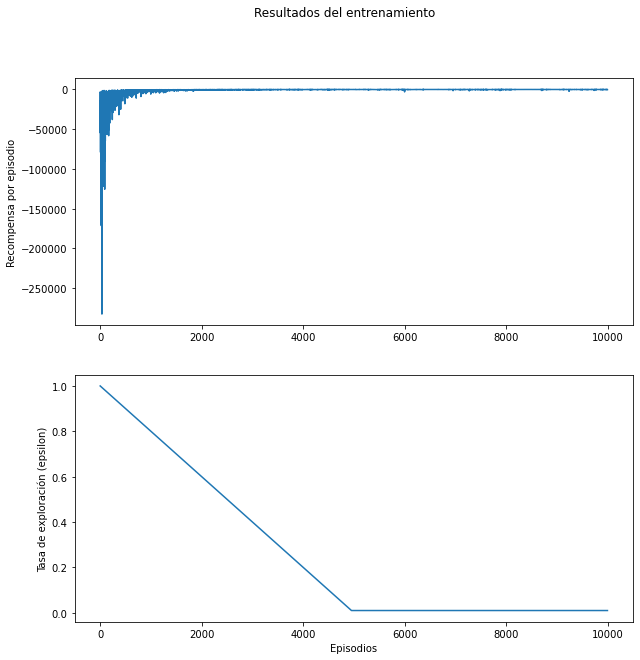

In [6]:
mountaincar = MountainCar()
qfunction = QTable()
QLearningMountainCar(mountaincar, EpsilonGreedy(), qfunction).execute(episodes=10000)

## Resolucion del problema mediante Sarsa

episode: 0, score: 0, epsilon: 1.000
episode: 100, score: -3779.0, epsilon: 0.980
episode: 200, score: -5491.0, epsilon: 0.960
episode: 300, score: -19050.0, epsilon: 0.940
episode: 400, score: -2403.0, epsilon: 0.920
episode: 500, score: -1498.0, epsilon: 0.900
episode: 600, score: -2866.0, epsilon: 0.880
episode: 700, score: -2007.0, epsilon: 0.860
episode: 800, score: -3279.0, epsilon: 0.840
episode: 900, score: -1241.0, epsilon: 0.820
episode: 1000, score: -845.0, epsilon: 0.800
episode: 1100, score: -1055.0, epsilon: 0.780
episode: 1200, score: -752.0, epsilon: 0.760
episode: 1300, score: -1273.0, epsilon: 0.740
episode: 1400, score: -629.0, epsilon: 0.720
episode: 1500, score: -389.0, epsilon: 0.700
episode: 1600, score: -436.0, epsilon: 0.680
episode: 1700, score: -406.0, epsilon: 0.660
episode: 1800, score: -424.0, epsilon: 0.640
episode: 1900, score: -376.0, epsilon: 0.620
episode: 2000, score: -349.0, epsilon: 0.600
episode: 2100, score: -447.0, epsilon: 0.580
episode: 2200, 

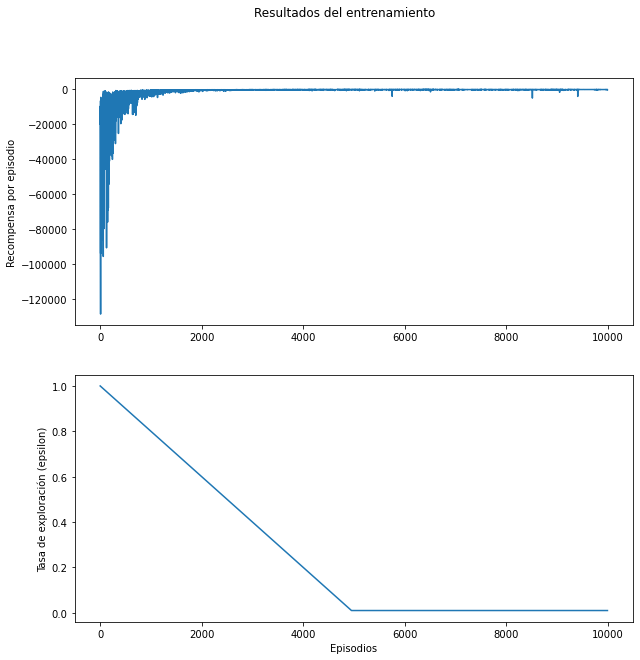

In [3]:
mountaincar = MountainCar()
qfunction = QTable()
SARSAMountainCar(mountaincar, EpsilonGreedy(), qfunction,print_info=False).execute(episodes=10000)

Podemos ver que tanto con Q-learning como con SARSA, a partir de los 1000 episodios es cuando empieza a decrecer el número de recompensas negativas.